In [ ]:
#### Comtrade Sample API Call
## GET https://comtradeapi.un.org/data/v1/get/C/A/HS?period=2022,2023
## &partnerCode=842&cmdCode=2707,270710,270720,270730,270740,270750,270760,270791,270799
## &aggregateBy=cmdCode&breakdownMode=classic&includeDesc=false HTTP/1.1
####
comtrade_subscription_key = '876b8944490d4539bde1e94f2a76e875'  ## Yash's Primary key for UN Comtrade

us_exim_oil_petrol_df = 
comtradeapicall.getFinalData(comtrade_subscription_key, typeCode='C', freqCode='M', clCode='HS', 
period='202301,202302,202303,202304,202305,202306,202307,202308,202309,202310,202311,202312',reporterCode='842', 
cmdCode='2707,270710,270720,270730,270740,270750,270760,270791,270799,2711,271111,271112,271113,271114,271119,271121,271129', 
flowCode='M,X', partnerCode=None, partner2Code=None, customsCode=None, motCode=None,  format_output='JSON',
aggregateBy=None, breakdownMode='classic', countOnly=None, includeDesc=True) 

## 201001,201002,201003,201004,201005,201006,201007,201008,201009,201010,201011,201012
## 201101,201102,201103,201104,201105,201106,201107,201108,201109,201110,201111,201112
## 201201,201202,201203,201204,201205,201206,201207,201208,201209,201210,201211,201212
## 201301,201302,201303,201304,201305,201306,201307,201308,201309,201310,201311,201312
## 201401,201402,201403,201404,201405,201406,201407,201408,201409,201410,201411,201412
## 201501,201502,201503,201504,201505,201506,201507,201508,201509,201510,201511,201512
## 201601,201602,201603,201604,201605,201606,201607,201608,201609,201610,201611,201612
## 201701,201702,201703,201704,201705,201706,201707,201708,201709,201710,201711,201712
## 201801,201802,201803,201804,201805,201806,201807,201808,201809,201810,201811,201812
## 201901,201902,201903,201904,201905,201906,201907,201908,201909,201910,201911,201912
## 202001,202002,202003,202004,202005,202006,202007,202008,202009,202010,202011,202012
## 202101,202102,202103,202104,202105,202106,202107,202108,202109,202110,202111,202112
## 202201,202202,202203,202204,202205,202206,202027,202208,202209,202210,202211,202212
## 202301,202302,202303,202304,202305,202306,202307,202308,202309,202310,202311,202312

### Combine all data into a single dataframe for UN ComTrade from 2010-2023
folder_path = 'C:/Users/.../Downloads/Comtrade/'
excel_files = glob.glob(folder_path + '*.xlsx')  

dfs = []
for file in excel_files:
    df = pd.read_excel(file)
    dfs.append(df)

us_exim_oil_petrol_df = pd.concat(dfs, ignore_index=True)
us_exim_oil_petrol_df.to_excel('USA_TradeData_Oil_Petroleum_2010_2023_HS2707_HS2711+.xlsx')


!pip install missingno # package required for missingness plots

In [33]:
import numpy as np 
import pandas as pd 
import matplotlib as mpl
import matplotlib.pyplot as plt  
import seaborn as sns             
from statsmodels.tsa.seasonal import seasonal_decompose
from IPython.display import display, HTML
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [34]:
#UN ComTrade Data Prepocessing

df = pd.read_excel('USA_TradeData_Oil_Petroleum_2010_2023_HS2707_HS2711+_clean.xlsx')
# Convert the 'refPeriodId' to datetime for Time Series Analysis
df['Date'] = pd.to_datetime(df['refPeriodId'], format="%Y%m%d")

# Create Import, Export columns
df['ImportValue'] = np.where(df['flowDesc'] == 'Export', 0, df['primaryValue'])
df['ExportValue'] = np.where(df['flowDesc'] == 'Import', 0, df['primaryValue'])
df['ImportQty'] = np.where(df['flowDesc'] == 'Export', 0, df['qty'])
df['ExportQty'] = np.where(df['flowDesc'] == 'Import', 0, df['qty'])

# Convert specific columns from int64 to object
obj_cols = ['reporterCode','partnerCode','cmdCode']
df[obj_cols] = df[obj_cols].astype('object')

# Filter the 'partnerISO' column to exclude 'W00' as this holds the aggregate of all countries trade statistics
df= df[df['partnerISO'] != 'W00']

# Comprehnsive dataset overview
print("Dataset Overview:")
info = pd.DataFrame({'Non-Null Count': df.count(), 'Null Count': df.isnull().sum()})
info['Null %'] = (info['Null Count'] / (info['Null Count'] + info['Non-Null Count'])) * 100
info['Null %'] = info['Null %'].round(1)
info['Unique Values'] = df.nunique()
#info['Data Type'] = df.dtypes
print(info)

print("\n")

print("Dataset Sample:")
display(df.head())

# Display overview in a more organized way

print(f"Number of observations: {len(df)}")
print(f"Number of variables: {len(df.columns)}")

# Display categorical and numeric variables
categorical_vars = [col for col in df.columns if df[col].dtype == 'O']
numeric_vars = [col for col in df.columns if df[col].dtype in ['int64', 'float64']]

print("\nVariable Types:")
print(f"  Categorical variables: {', '.join(categorical_vars)}")
print(f"  Numeric variables: {', '.join(numeric_vars)}")

Dataset Overview:
                     Non-Null Count  Null Count  Null %  Unique Values
refPeriodId                   57924           0     0.0            166
refYear                       57924           0     0.0             14
refMonth                      57924           0     0.0             12
period                        57924           0     0.0            166
reporterCode                  57924           0     0.0              1
reporterDesc                  57924           0     0.0              1
flowDesc                      57924           0     0.0              2
partnerCode                   57924           0     0.0            172
partnerISO                    57924           0     0.0            172
partnerDesc                   57924           0     0.0            172
cmdCode                       57924           0     0.0             16
cmdDesc                       57924           0     0.0             18
qtyUnitCode                   57924           0     0.0    

refPeriodId  refYear  refMonth  period reporterCode reporterDesc flowDesc  \
0     20100101     2010         1  201001          842          USA   Import   
1     20100101     2010         1  201001          842          USA   Import   
2     20100101     2010         1  201001          842          USA   Import   
3     20100101     2010         1  201001          842          USA   Import   
4     20100101     2010         1  201001          842          USA   Import   

  partnerCode partnerISO partnerDesc  ... grossWgt isGrossWgtEstimated  \
0         156        CHN       China  ...      NaN               False   
1         156        CHN       China  ...      NaN               False   
2         124        CAN      Canada  ...      NaN               False   
3         124        CAN      Canada  ...      NaN               False   
4         124        CAN      Canada  ...      NaN               False   

    cifvalue fobvalue  primaryValue       Date  ImportValue ExportValue  \
0    22805.0      NaN         22805 2010-01-01        22805           0   
1   154173.0      NaN        154173 2010-01-01       154173           0   
2  4609744.0      NaN       4609744 2010-01-01      4609744           0   
3   694107.0      NaN        694107 2010-01-01       694107           0   
4    12560.0      NaN         12560 2010-01-01        12560           0   

   ImportQty  ExportQty  
0        NaN        0.0  
1        NaN        0.0  
2        NaN        0.0  
3        NaN        0.0  
4        NaN        0.0  

[5 rows x 32 columns]

Number of observations: 57924
Number of variables: 32

Variable Types:
  Categorical variables: reporterCode, reporterDesc, flowDesc, partnerCode, partnerISO, partnerDesc, cmdCode, cmdDesc, qtyUnitAbbr, altQtyUnitAbbr
  Numeric variables: refPeriodId, refYear, refMonth, period, qtyUnitCode, qty, altQtyUnitCode, altQty, netWgt, grossWgt, cifvalue, fobvalue, primaryValue, ImportValue, ExportValue, ImportQty, ExportQty


Descriptive Statistics for Categorical Variables:

reporterDesc Frequency Distribution:
reporterDesc  Count
         USA  57924

Mode for reporterDesc: USA


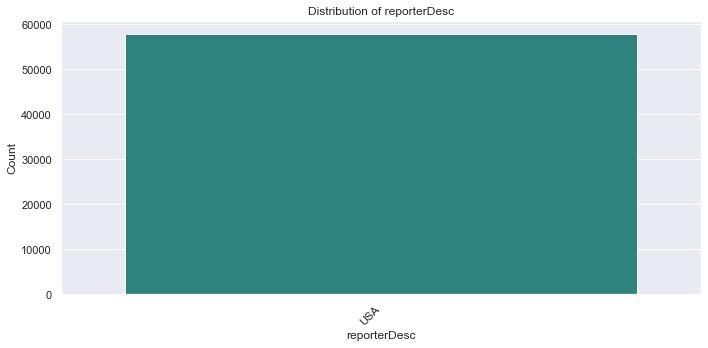

-----------------------------------------------------------------------------------------------------------------------------

flowDesc Frequency Distribution:
flowDesc  Count
  Export  44660
  Import  13264

Mode for flowDesc: Export


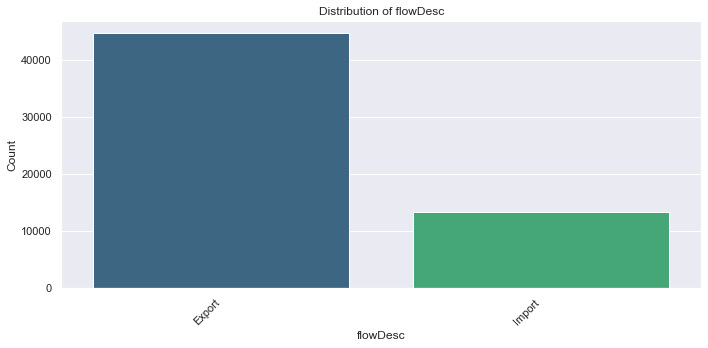

-----------------------------------------------------------------------------------------------------------------------------

partnerDesc Frequency Distribution:
                     partnerDesc  Count
                          Canada   4632
                          Mexico   2974
                   Rep. of Korea   2253
                           China   2016
                           Japan   1680
                     Netherlands   1601
                  United Kingdom   1589
                         Germany   1513
                          Brazil   1485
                          France   1301
                         Belgium   1242
             Trinidad and Tobago   1186
                  Dominican Rep.   1108
                      Costa Rica   1074
                           India   1024
                            Peru    975
                       Australia    942
                        Colombia    925
                           Spain    907
                       Argentina    8

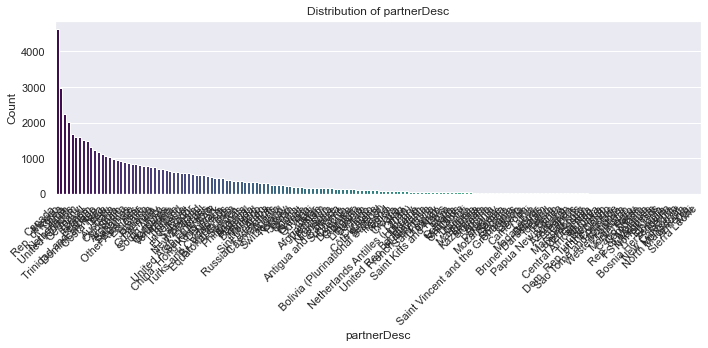

-----------------------------------------------------------------------------------------------------------------------------

cmdCode Frequency Distribution:
 cmdCode  Count
    2711  11916
    2707   8643
  271112   6087
  270799   4765
  271119   3927
  271113   3695
  270750   3525
  271129   3006
  271111   2752
  271114   2689
  270730   2412
  270720   1509
  270740    948
  271121    738
  270710    714
  270791    598

Mode for cmdCode: 2711


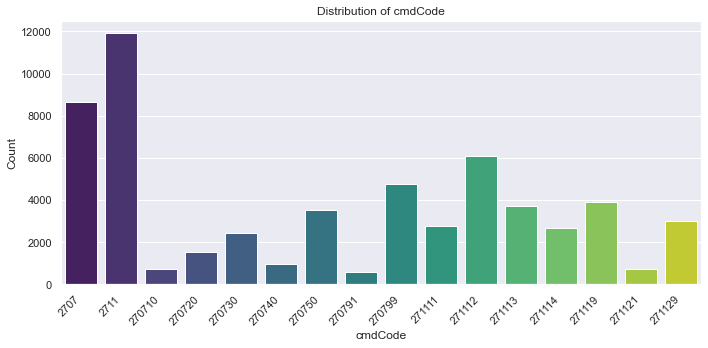

-----------------------------------------------------------------------------------------------------------------------------

cmdDesc Frequency Distribution:
                                                                                                                                                                                                cmdDesc  Count
                                                                                                                                                         Petroleum gases and other gaseous hydrocarbons  11916
              Oils and other products of the distillation of high temperature coal tar; similar products in which the weight of the aromatic constituents exceeds that of the non-aromatic constituents   8643
                                                                                                                                     Petroleum gases and other gaseous hydrocarbons; liquefied, propane   6087
             

C:\Users\trader72\AppData\Local\Temp\ipykernel_11800\386470668.py:24: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()  # Adjust layout to prevent clipping


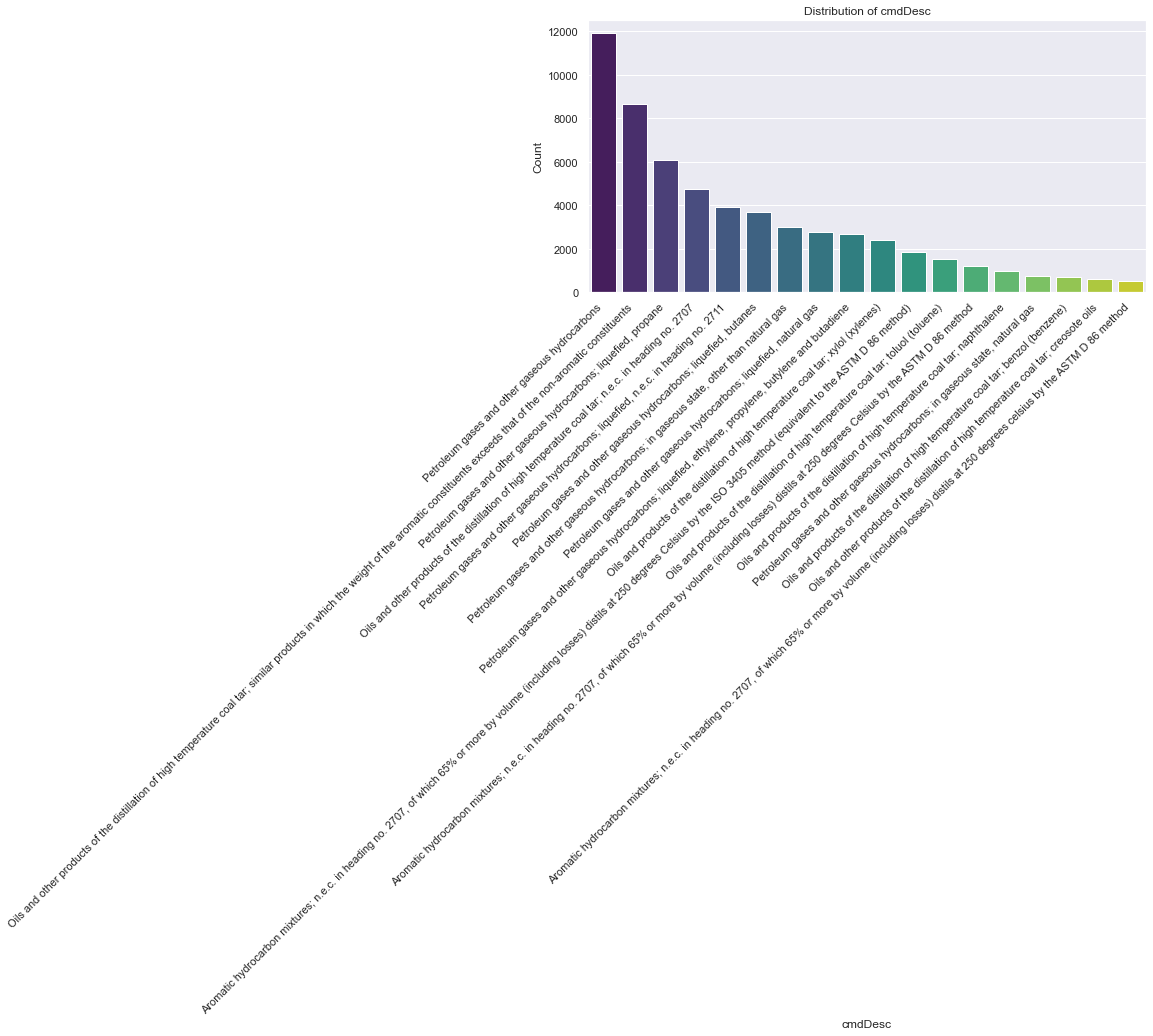

-----------------------------------------------------------------------------------------------------------------------------


In [35]:
# Keep specific columns
selected_columns = ['Date', 'reporterDesc', 'flowDesc', 'partnerDesc', 'cmdCode', 
                    'cmdDesc', 'ImportQty', 'ImportValue', 'ExportQty', 'ExportValue']
df = df[selected_columns]
#df = df[~df['cmdCode'].isin([2707,270710,270720,270730,270740,270750,270750,270791,270799])]
# Display overview
print("Descriptive Statistics for Categorical Variables:")
for col in df.columns:
    if df[col].dtype == 'O':
        # Frequency distribution
        frequency_table = df[col].value_counts().reset_index().rename(columns={col: 'Count', 'index': col})
        print(f"\n{col} Frequency Distribution:")
        print(frequency_table.to_string(index=False))

        # Mode
        mode_value = df[col].mode().values[0]
        print(f"\nMode for {col}: {mode_value}")

        # Bar Chart using Seaborn with rotated x-axis labels and adjusted figure size
        plt.figure(figsize=(10, 5))
        sns.barplot(x=col, y='Count', data=frequency_table, palette='viridis')
        plt.title(f'Distribution of {col}')
        plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
        plt.tight_layout()  # Adjust layout to prevent clipping
        plt.show()
        print('-' * 125)  
        


Descriptive Statistics for Country Partners

ExportValue Frequency Distribution:
         partnerDesc  Count
0             Canada   4632
1             Mexico   2974
2      Rep. of Korea   2253
3              China   2016
4              Japan   1680
..               ...    ...
167       Montserrat      2
168  North Macedonia      2
169          Armenia      2
170             Mali      2
171     Sierra Leone      2

[172 rows x 2 columns]


C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


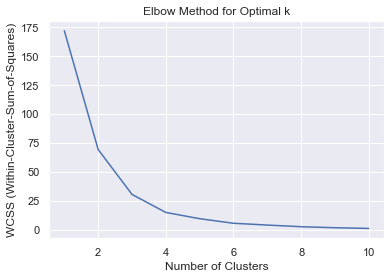

Clustered Data:
         partnerDesc  Count  Cluster
0             Canada   4632        1
1             Mexico   2974        1
2      Rep. of Korea   2253        1
3              China   2016        1
4              Japan   1680        1
..               ...    ...      ...
167       Montserrat      2        0
168  North Macedonia      2        0
169          Armenia      2        0
170             Mali      2        0
171     Sierra Leone      2        0

[172 rows x 3 columns]

Mode for partnerDesc: Canada
            partnerDesc  Count  Cluster
0                Canada   4632        1
1                Mexico   2974        1
2         Rep. of Korea   2253        1
3                 China   2016        1
4                 Japan   1680        1
5           Netherlands   1601        1
6        United Kingdom   1589        1
7               Germany   1513        1
8                Brazil   1485        1
9                France   1301        1
10              Belgium   1242        1
11  Tr

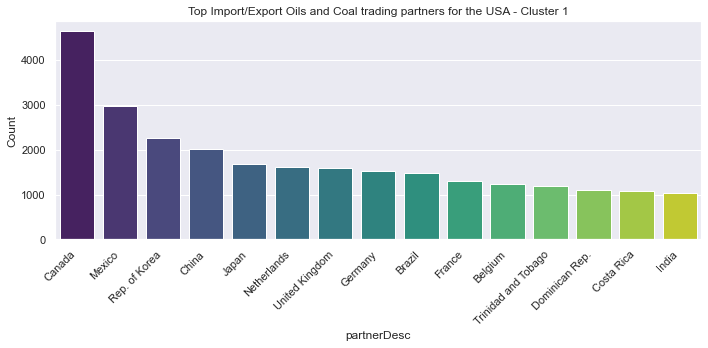

-----------------------------------------------------------------------------------------------------------------------------


In [36]:
# Keep specific columns
selected_columns = ['Date',  'partnerDesc','ImportQty', 'ImportValue', 'ExportQty', 'ExportValue']
#df = df[df['cmdCode'].isin([2707,270710,270720,270730,270740,270750,270750,270791,270799])] #toggle the ~ sign
df1 = df[selected_columns]

# Display overview
print("Descriptive Statistics for Country Partners")

frequency_table = df1['partnerDesc'].value_counts().reset_index().rename(columns={col: 'Count', 'index': col})
print(f"\n{col} Frequency Distribution:")
frequency_table = frequency_table.rename(columns={'ExportValue': 'partnerDesc', 'partnerDesc': 'Count'})
print(frequency_table)
# Select features for clustering (replace with actual features)
features_for_clustering = frequency_table[['Count']]

# Standardize the data
scaler = StandardScaler()
features_standardized = scaler.fit_transform(features_for_clustering)

# Determine the optimal number of clusters using the Elbow method
wcss = []  # Within-Cluster-Sum-of-Squares

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(features_standardized)
    wcss.append(kmeans.inertia_)

# Plot the Elbow method to find the optimal number of clusters
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS (Within-Cluster-Sum-of-Squares)')
plt.show()

# Based on the Elbow method, choose the optimal number of clusters (k)
optimal_k = 2

# Perform k-means clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42)
frequency_table['Cluster'] = kmeans.fit_predict(features_standardized)

# Display the clustered data
print("Clustered Data:")
print(frequency_table)

# Mode
mode_value = df1['partnerDesc'].mode().values[0]
print(f"\nMode for partnerDesc: {mode_value}")

# Bar Chart using Seaborn with rotated x-axis labels and adjusted figure size
ftc1 = frequency_table[frequency_table['Cluster'] == 1]
print(ftc1)
#ftc0 = frequency_table[frequency_table['Cluster'] == 0]

plt.figure(figsize=(10, 5))
sns.barplot(x='partnerDesc', y='Count', data=ftc1, palette='viridis')
plt.title(f'Top Import/Export Oils and Coal trading partners for the USA - Cluster 1')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()
print('-' * 125)

In [37]:
# Get unique cmdCode 
unique_cmdCodes = df['cmdCode'].unique()
sub_dataframes = {}
for cmdCode in unique_cmdCodes:
    sub_df = df[df['cmdCode'] == cmdCode]

    sub_df = sub_df.groupby(['Date', 'partnerDesc', 'cmdDesc', 'cmdCode']).agg({
        'ImportValue': 'sum',
        'ImportQty': 'sum',
        'ExportValue': 'sum',
        'ExportQty': 'sum',
    }).reset_index()
    
    sub_dataframes[cmdCode] = sub_df

# Access individual sub DataFrames using their cmdCode values
'''for cmdCode, sub_df in sub_dataframes.items():
    print(f"DataFrame for cmdCode {cmdCode}:\n")
    print(sub_df)
    print("\n----------------\n")'''

# To access individual sub DataFrames using their cmdCode value
print(sub_dataframes[2707].info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6848 entries, 0 to 6847
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         6848 non-null   datetime64[ns]
 1   partnerDesc  6848 non-null   object        
 2   cmdDesc      6848 non-null   object        
 3   cmdCode      6848 non-null   int64         
 4   ImportValue  6848 non-null   int64         
 5   ImportQty    6848 non-null   float64       
 6   ExportValue  6848 non-null   int64         
 7   ExportQty    6848 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(3), object(2)
memory usage: 428.1+ KB
None


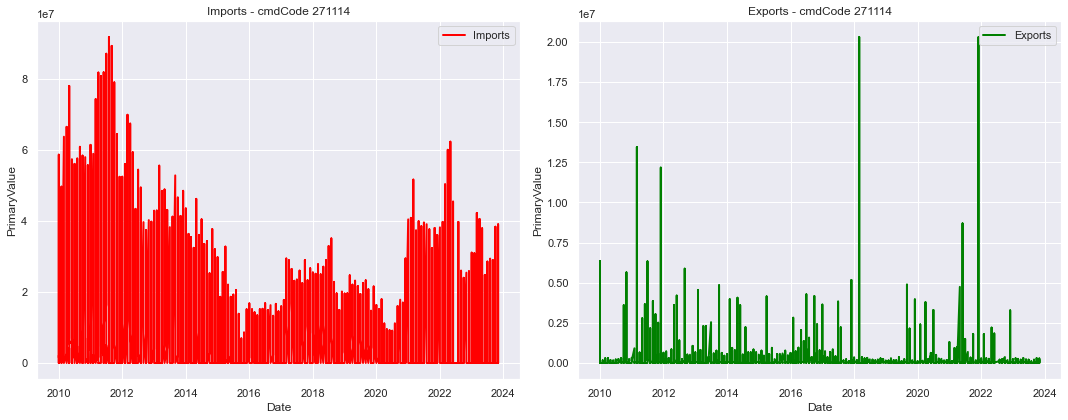

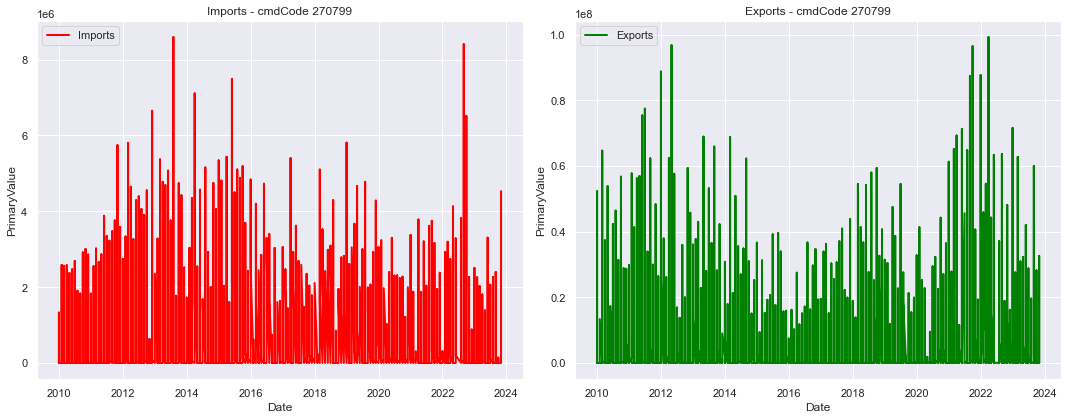

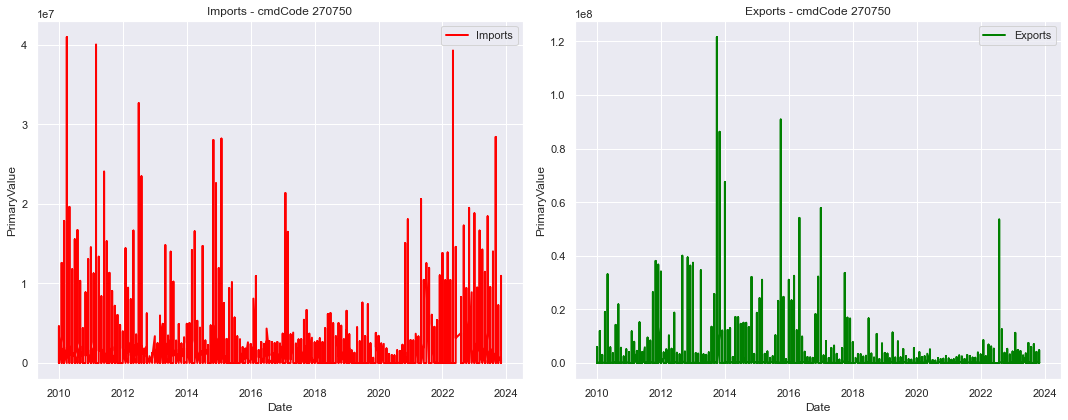

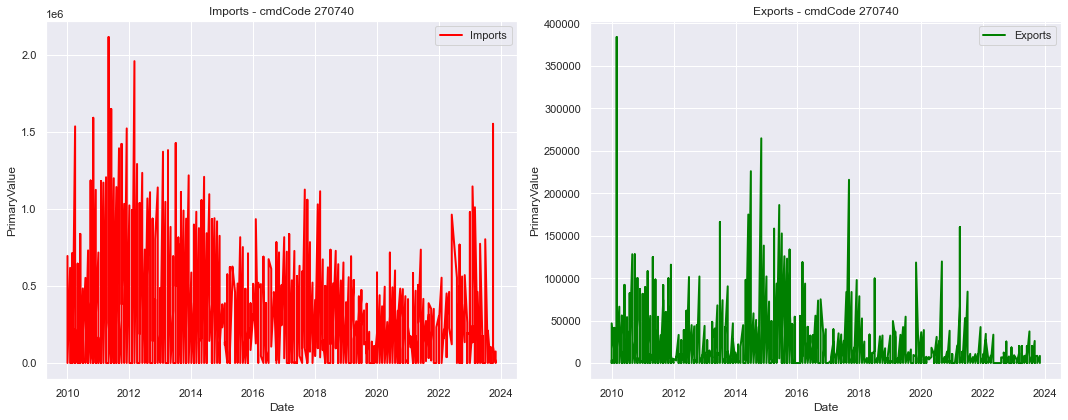

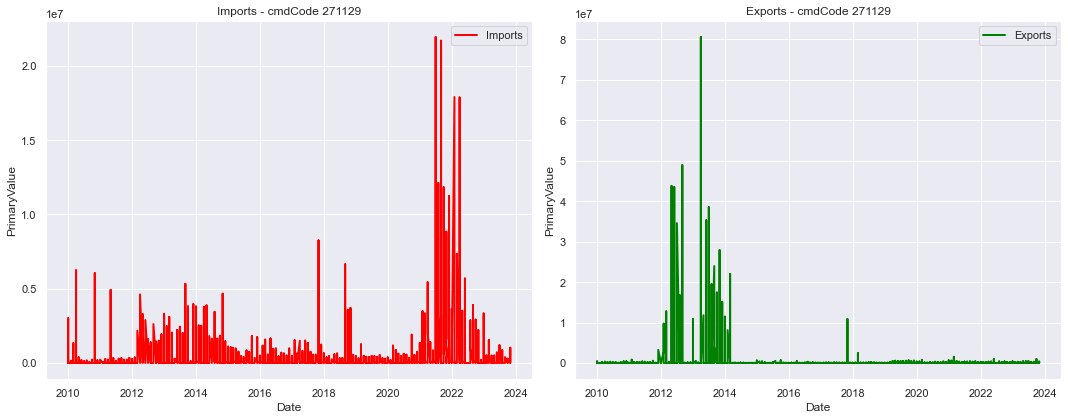

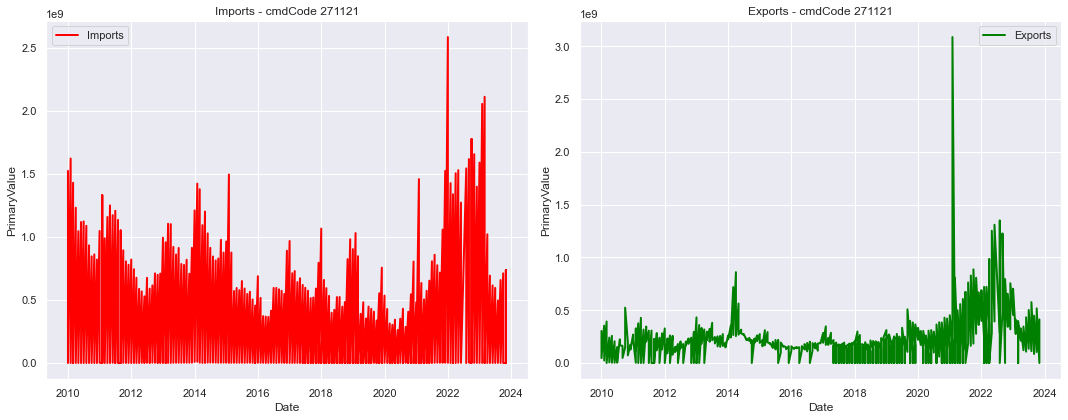

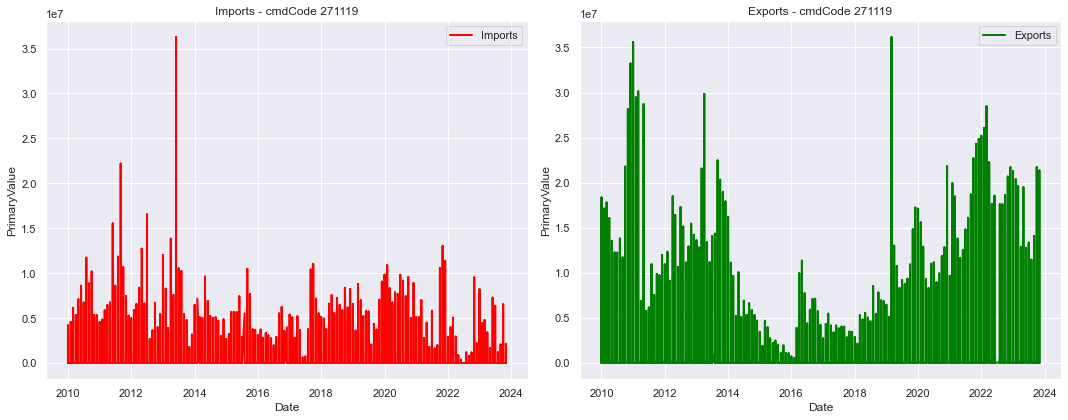

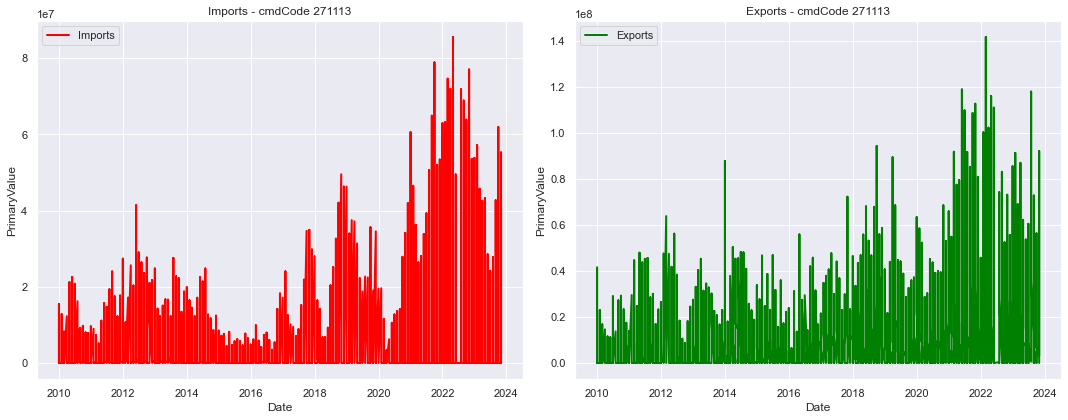

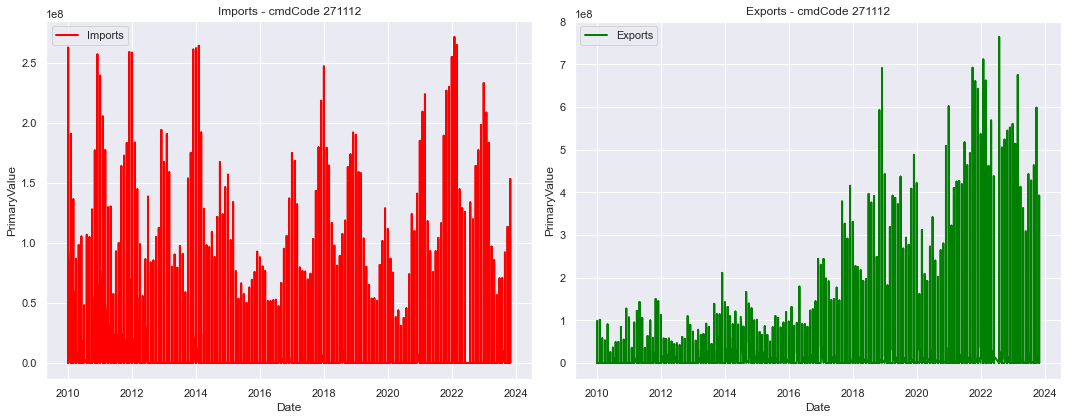

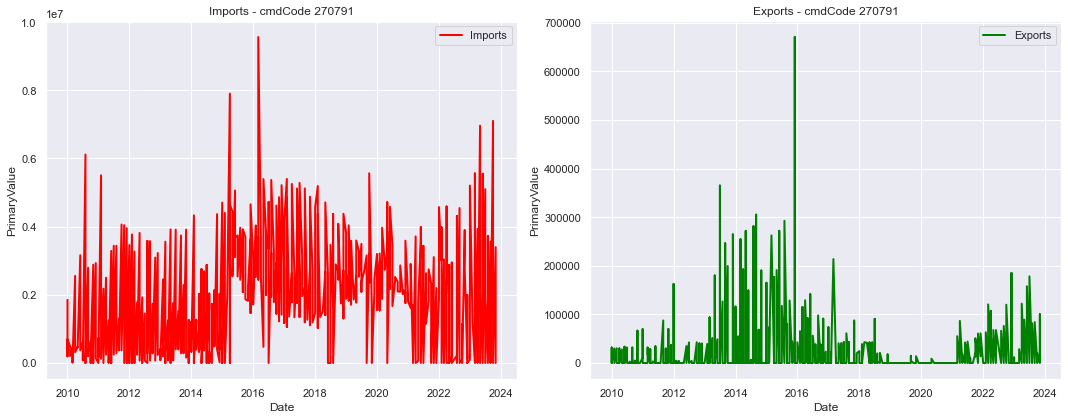

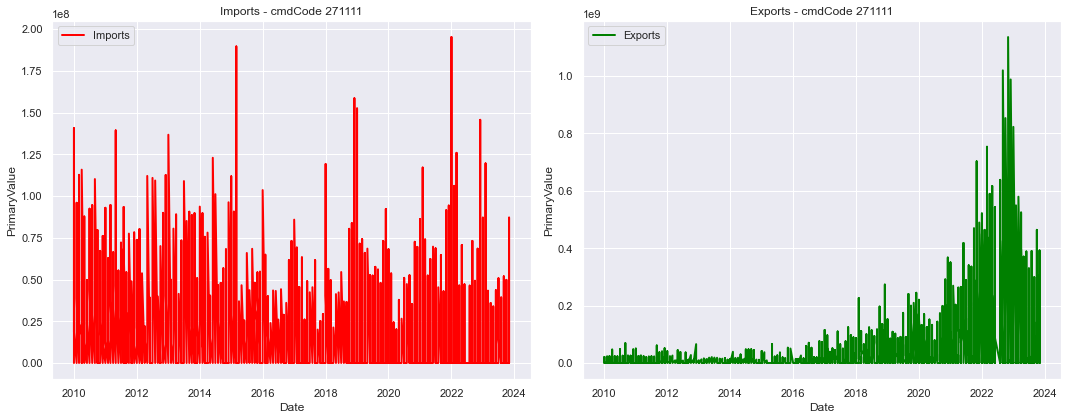

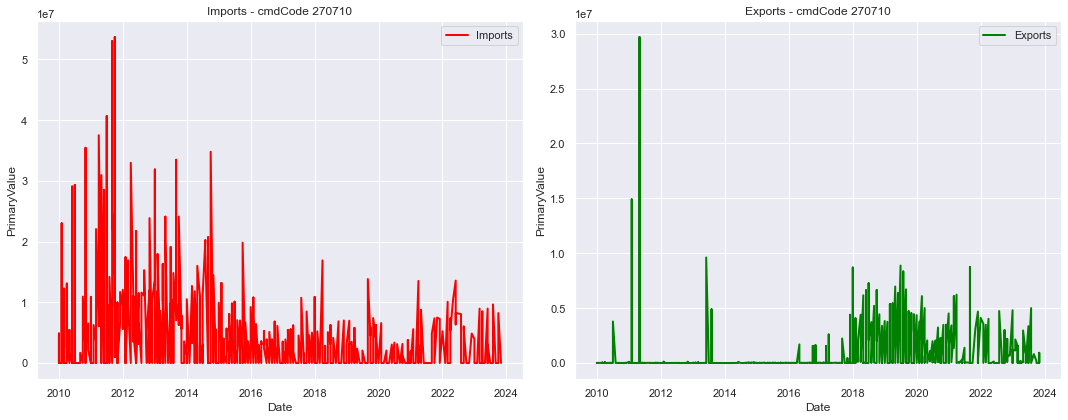

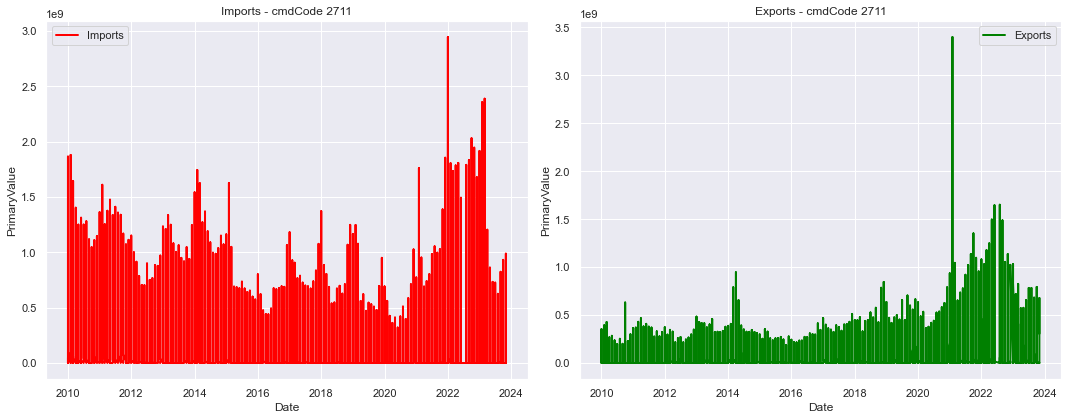

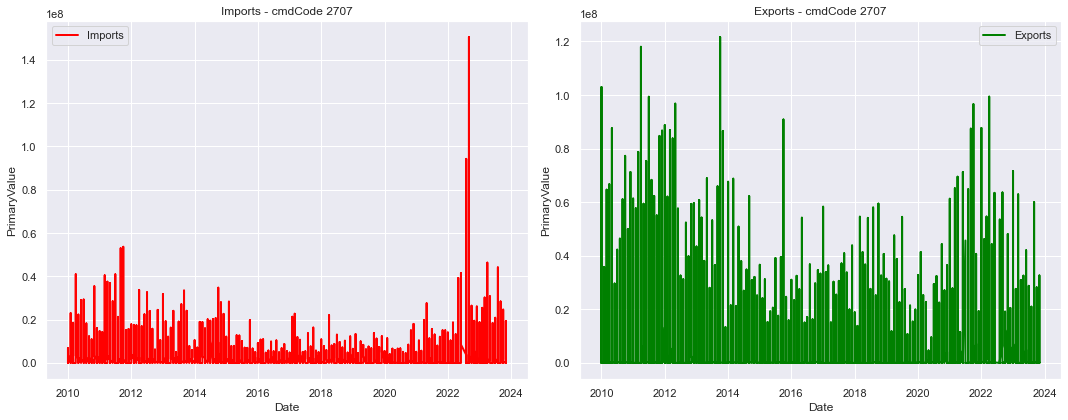

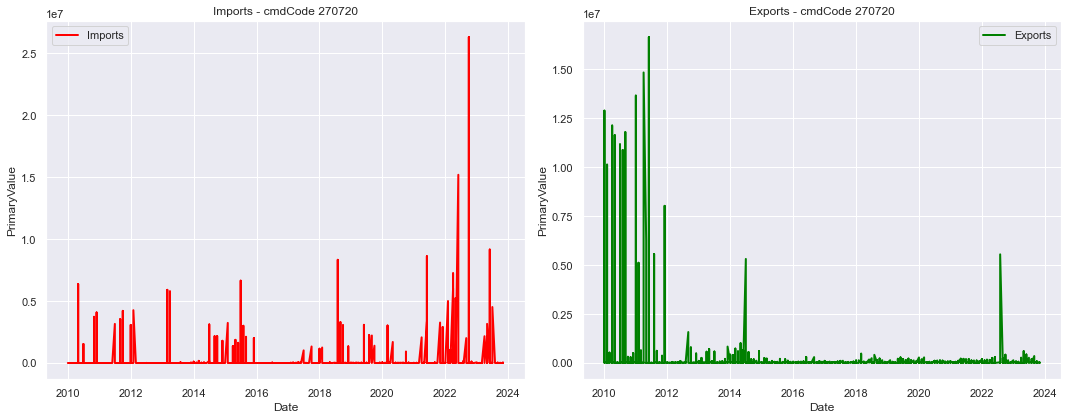

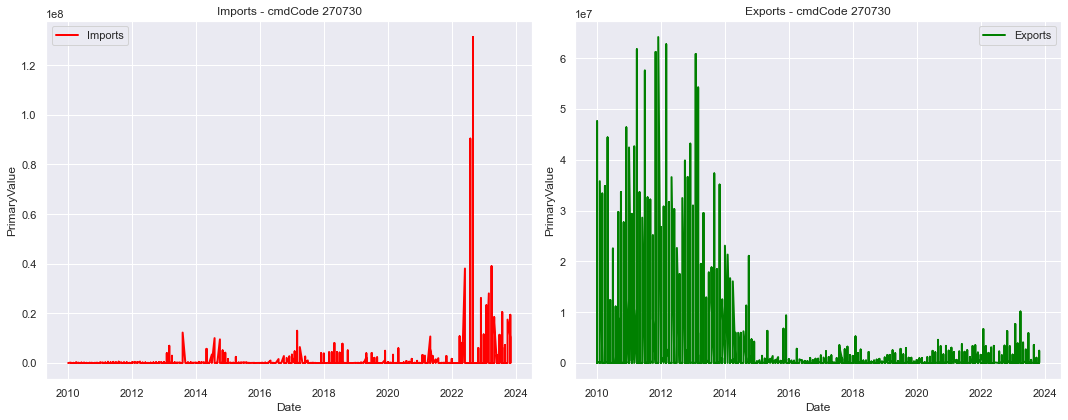

In [38]:
# Loop over all elements in the sub_dataframes dictionary
for cmdCode, sub_df in sub_dataframes.items():
    # Create subplots with 1 row and 2 columns
    fig, axs = plt.subplots(1, 2, figsize=(15, 6))

    # Plotting the first subplot (Imports) with color 'red'
    axs[0].plot(sub_df['Date'], sub_df['ImportValue'], label='Imports', linewidth=2, color='red')
    axs[0].set_title(f'Imports - cmdCode {cmdCode}')
    axs[0].set_xlabel('Date')
    axs[0].set_ylabel('PrimaryValue')
    axs[0].legend()
    axs[0].grid(True)
    axs[0].xaxis_date()

    # Plotting the second subplot (Exports) with color 'green'
    axs[1].plot(sub_df['Date'], sub_df['ExportValue'], label='Exports', linewidth=2, color='green')
    axs[1].set_title(f'Exports - cmdCode {cmdCode}')
    axs[1].set_xlabel('Date')
    axs[1].set_ylabel('PrimaryValue')
    axs[1].legend()
    axs[1].grid(True)
    axs[1].xaxis_date()

    # Adjust layout for better spacing
    plt.tight_layout()

    # Show the plot for the current cmdCode
    plt.show()


In [39]:
unique_cmdCodes = sorted(unique_cmdCodes)
print(unique_cmdCodes)

[2707, 2711, 270710, 270720, 270730, 270740, 270750, 270791, 270799, 271111, 271112, 271113, 271114, 271119, 271121, 271129]


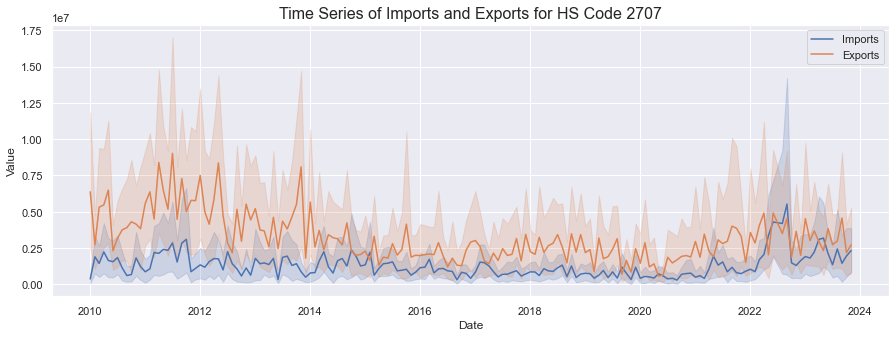

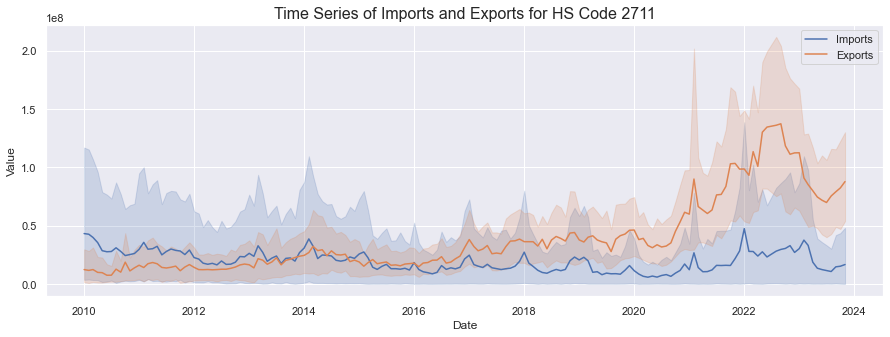

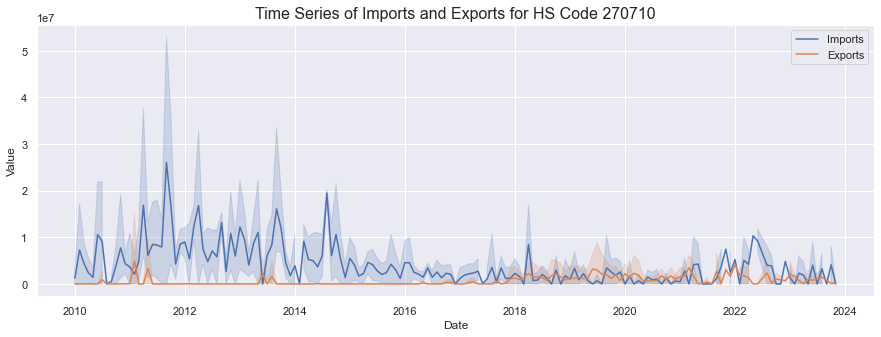

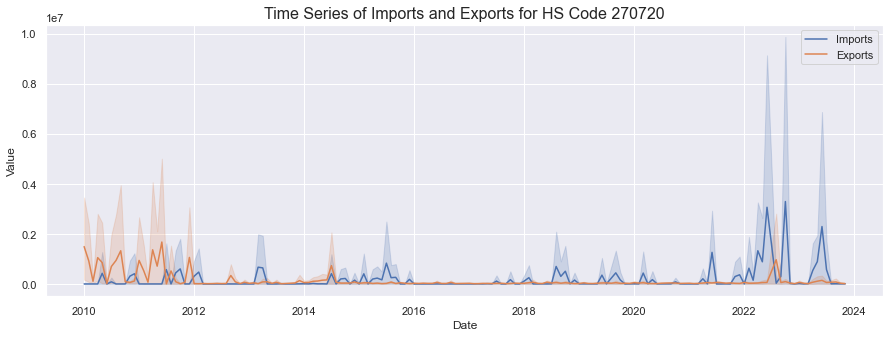

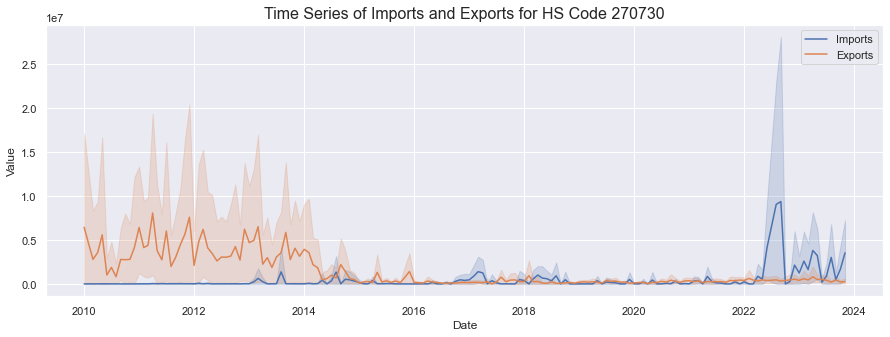

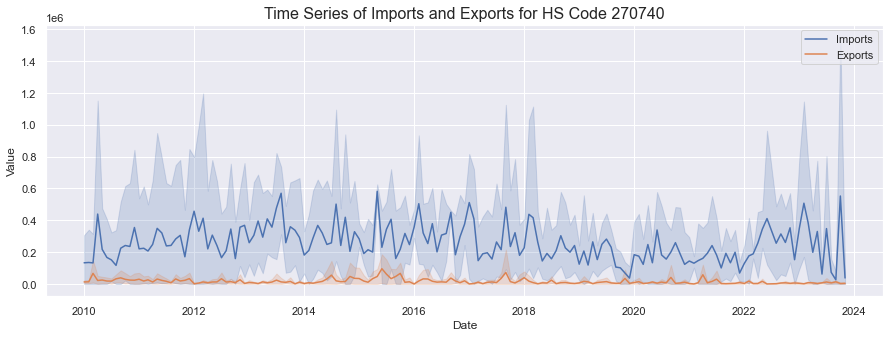

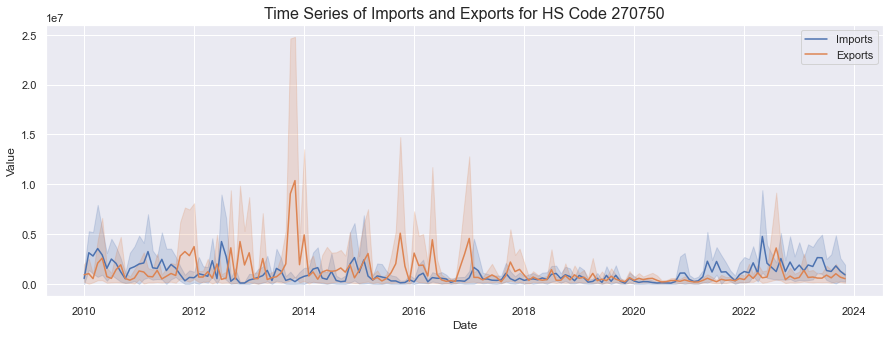

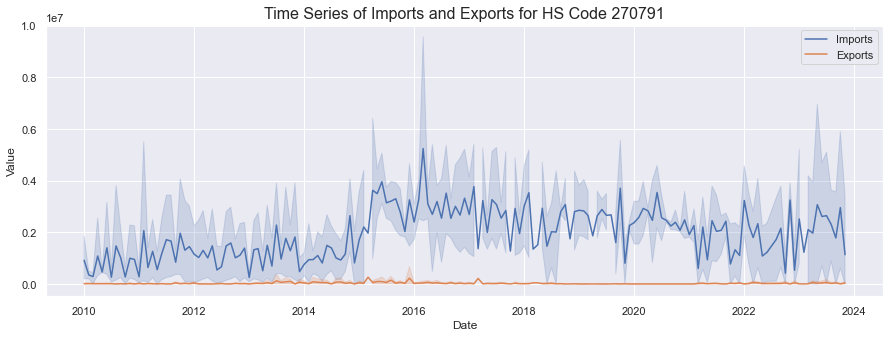

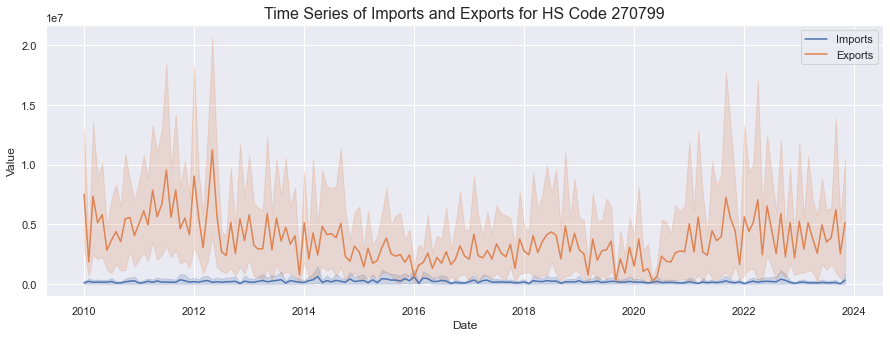

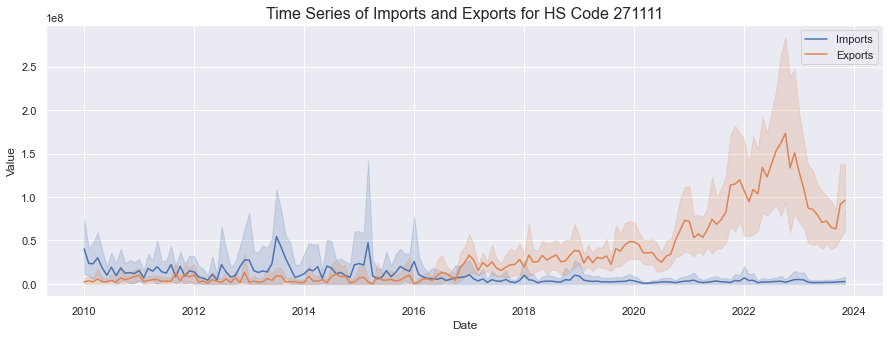

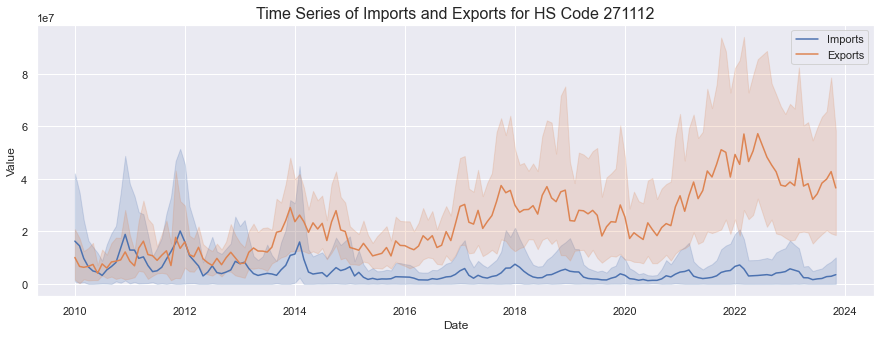

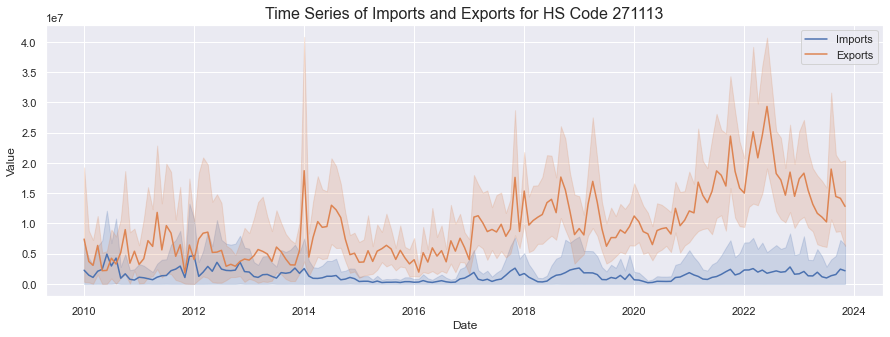

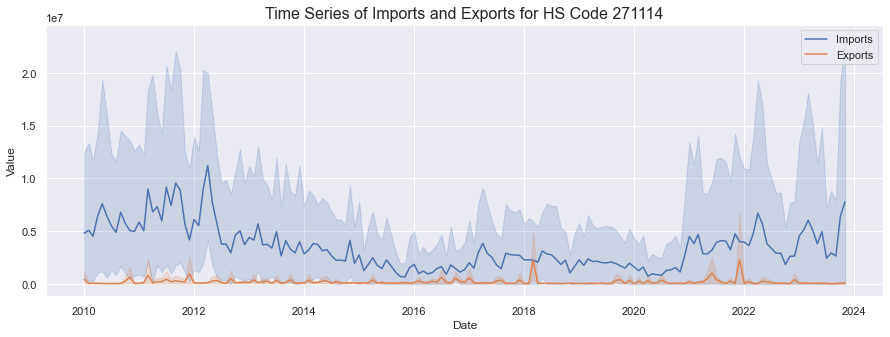

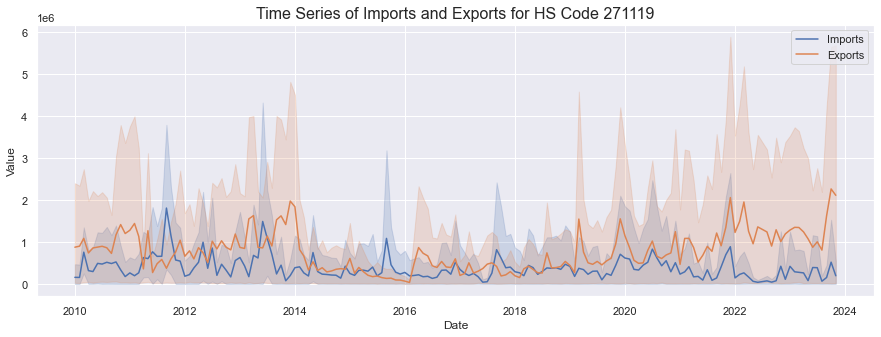

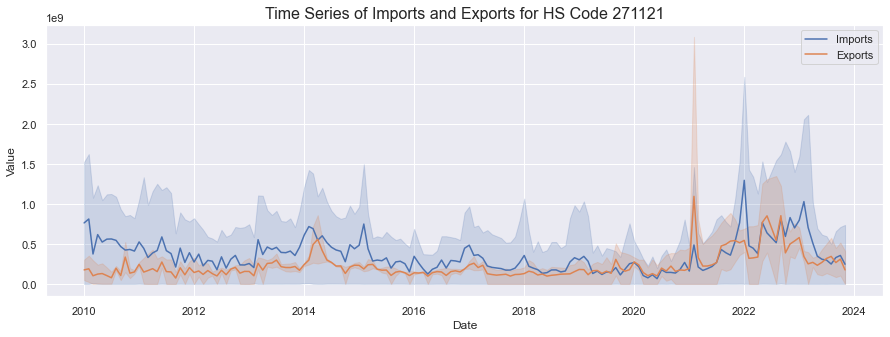

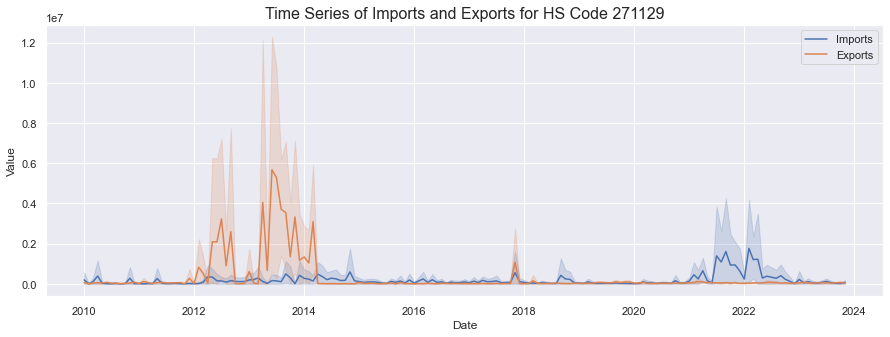

In [40]:
for cmdCode in unique_cmdCodes:
    product_df= sub_dataframes[cmdCode]
    plt.figure(figsize=(15, 5))
    # Creating line plots using seaborn
    sns.set()
    sns.lineplot(x='Date', y='ImportValue', data=product_df, label='Imports')
    sns.lineplot(x='Date', y='ExportValue', data=product_df, label='Exports')

    # Adding title and labels
    plt.title(f'Time Series of Imports and Exports for HS Code {cmdCode}', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Value', fontsize=12)

    # Adding a legend
    plt.legend()

    # Displaying the plot
    plt.show()

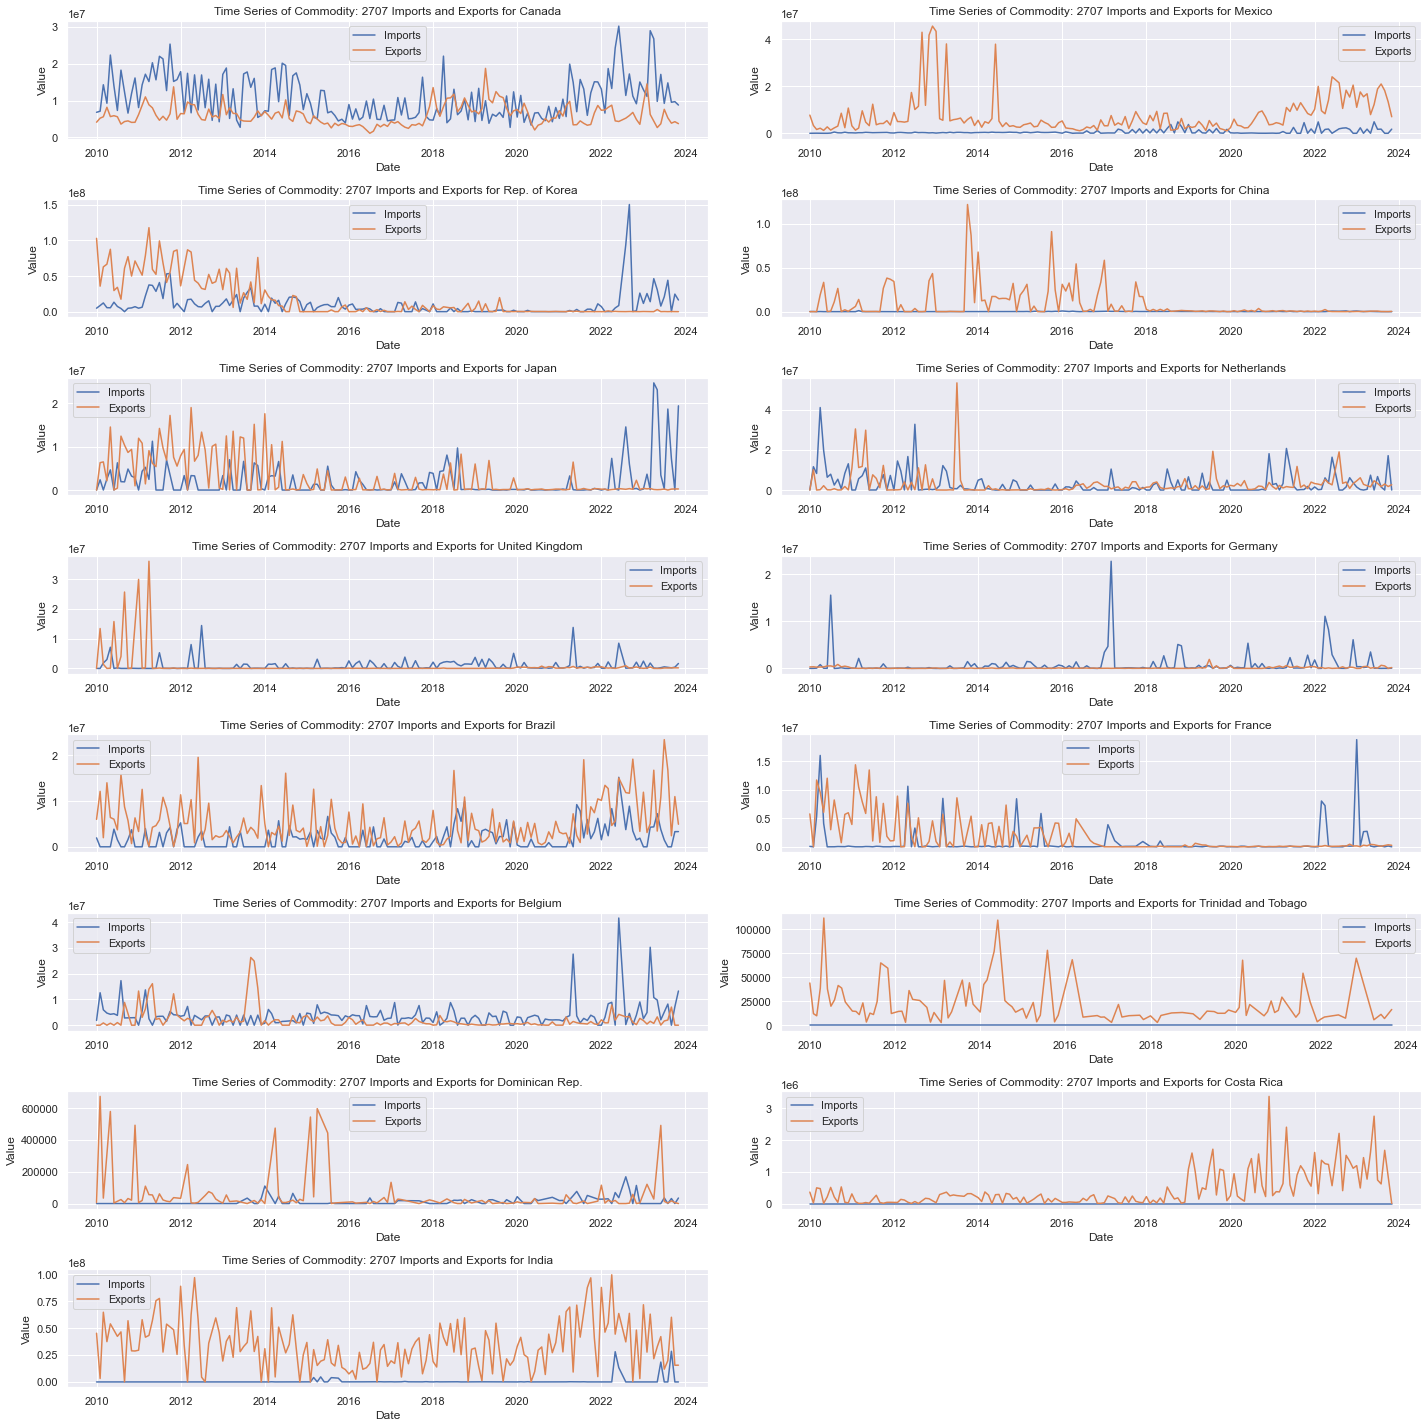

In [41]:
ctry = sub_dataframes[2707]

top_countries = ['Canada', 'Mexico', 'Rep. of Korea', 'China', 'Japan', 'Netherlands', 'United Kingdom',
                 'Germany', 'Brazil', 'France' , 'Belgium' , 'Trinidad and Tobago', 'Dominican Rep.', 'Costa Rica',  'India']


top_countries_df = ctry[ctry['partnerDesc'].isin(top_countries)]

plt.figure(figsize=(20, 20))

for i, country in enumerate(top_countries):
    plt.subplot(8, 2, i+1)  # Adjusts the subplot layout based on the number of countries
    country_df = top_countries_df[top_countries_df['partnerDesc'] == country]
    
    sns.lineplot(x='Date', y='ImportValue', data=country_df, label='Imports')
    sns.lineplot(x='Date', y='ExportValue', data=country_df, label='Exports')

    plt.title(f'Time Series of Commodity: 2707 Imports and Exports for {country}')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()

plt.tight_layout()
plt.show()

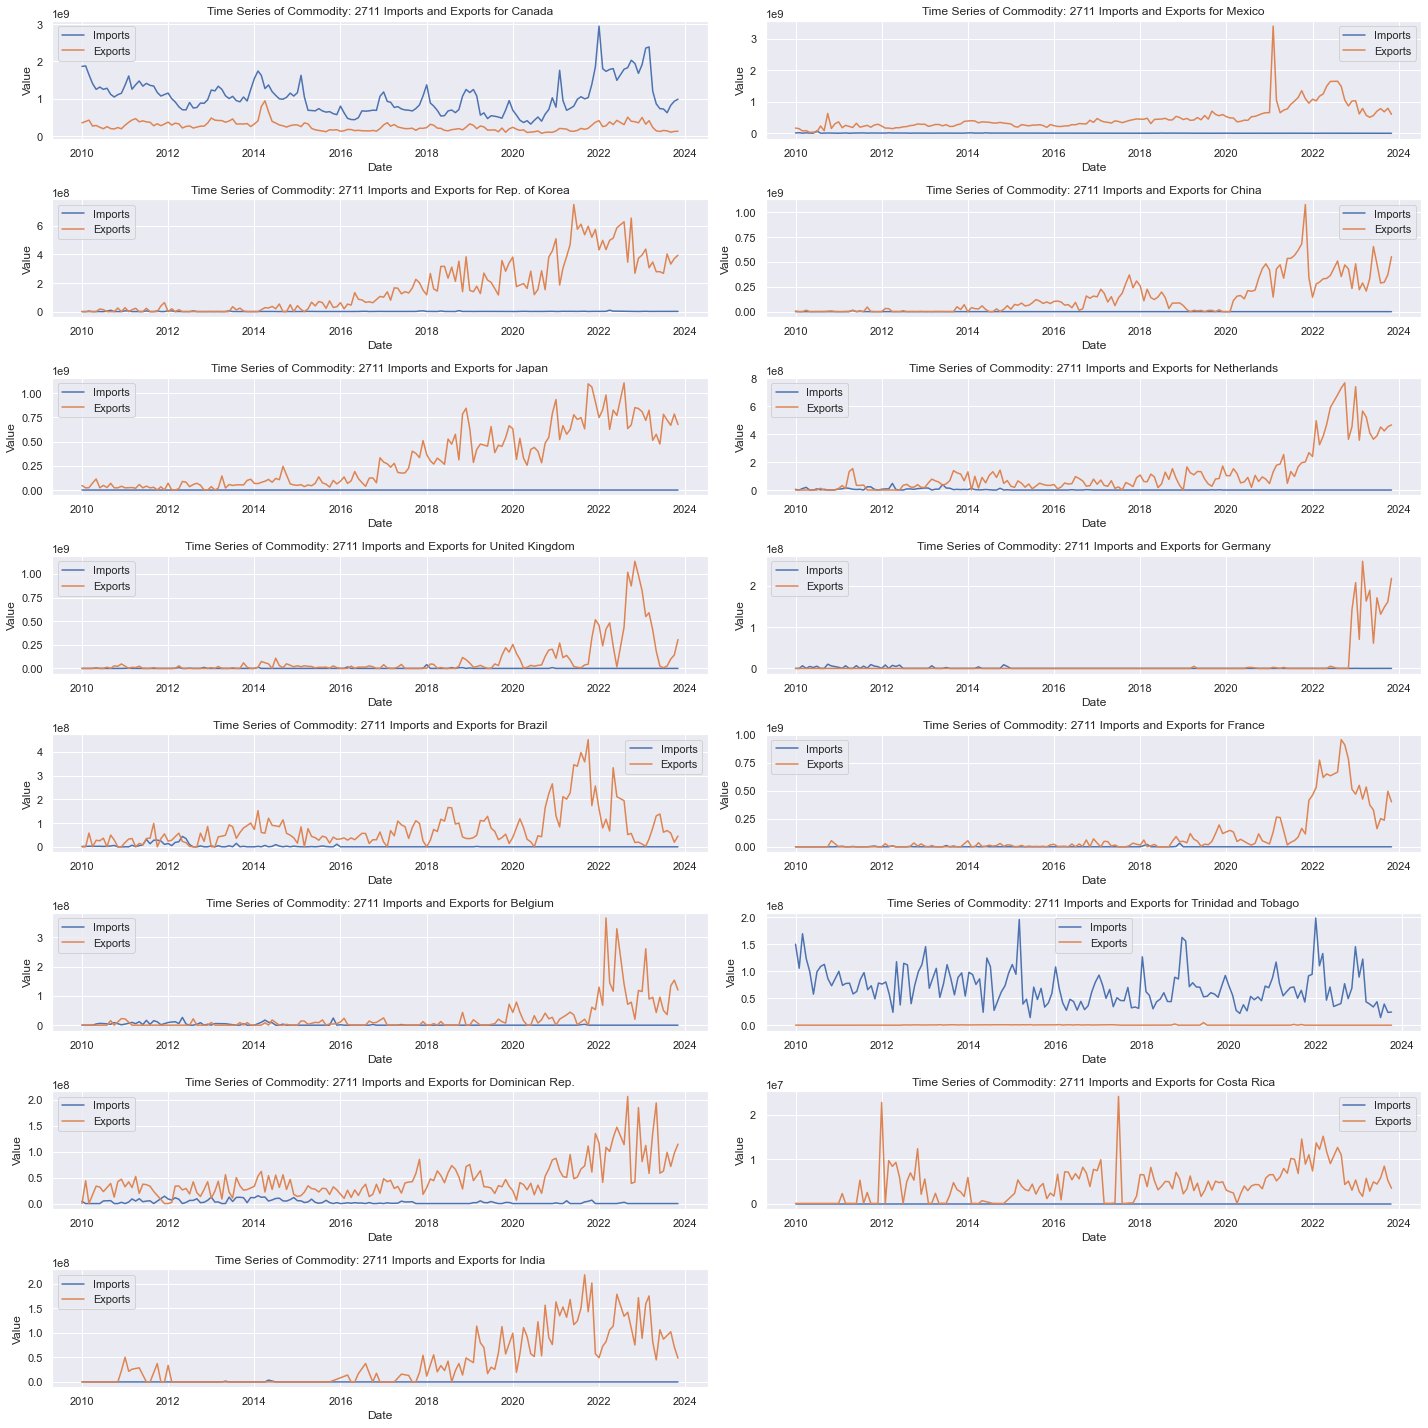

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns


ctry = sub_dataframes[2711]

top_countries = ['Canada', 'Mexico', 'Rep. of Korea', 'China', 'Japan', 'Netherlands', 'United Kingdom',
                 'Germany', 'Brazil', 'France' , 'Belgium' , 'Trinidad and Tobago', 'Dominican Rep.', 'Costa Rica',  'India']


top_countries_df = ctry[ctry['partnerDesc'].isin(top_countries)]

plt.figure(figsize=(20, 20))

for i, country in enumerate(top_countries):
    plt.subplot(8, 2, i+1)  # Adjusts the subplot layout based on the number of countries
    country_df = top_countries_df[top_countries_df['partnerDesc'] == country]
    
    sns.lineplot(x='Date', y='ImportValue', data=country_df, label='Imports')
    sns.lineplot(x='Date', y='ExportValue', data=country_df, label='Exports')

    plt.title(f'Time Series of Commodity: 2711 Imports and Exports for {country}')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()

plt.tight_layout()
plt.show()